# Denoising Autoencoder with MNIST
---
이 노트북에서는 MNIST 데이터셋을 활용하여 Denoising Autoencoder(DAE)를 구현하고 학습하는 실습을 진행합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

## 1. 데이터 준비

In [2]:
# MNIST 데이터 로드
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# 정규화 및 차원 변환
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


## 2. 노이즈 추가

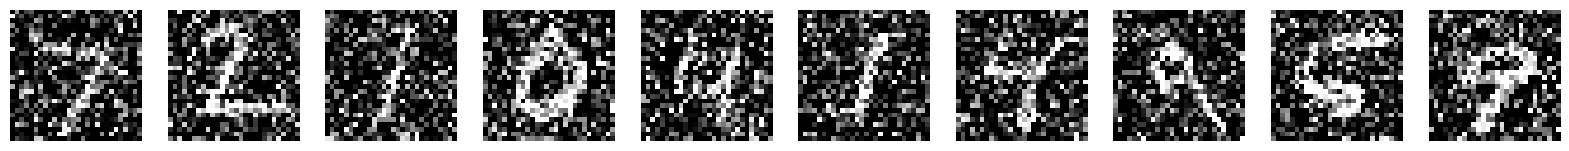

In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# 0~1 사이로 클리핑
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# 샘플 시각화
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.show()

## 3. Denoising Autoencoder 모델 정의

In [4]:
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

## 4. 모델 학습

In [5]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.1579 - val_loss: 0.1160
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - loss: 0.1129 - val_loss: 0.1093
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - loss: 0.1075 - val_loss: 0.1047
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 0.1048 - val_loss: 0.1029
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1029 - val_loss: 0.1011
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.1015 - val_loss: 0.0999
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - loss: 0.1003 - val_loss: 0.0988
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0993 - val_loss: 0.0982
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.0985 - val_loss: 0.0972
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 178ms/step - loss: 0.0979 - val_loss: 0.0969


## 5. 결과 시각화

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step


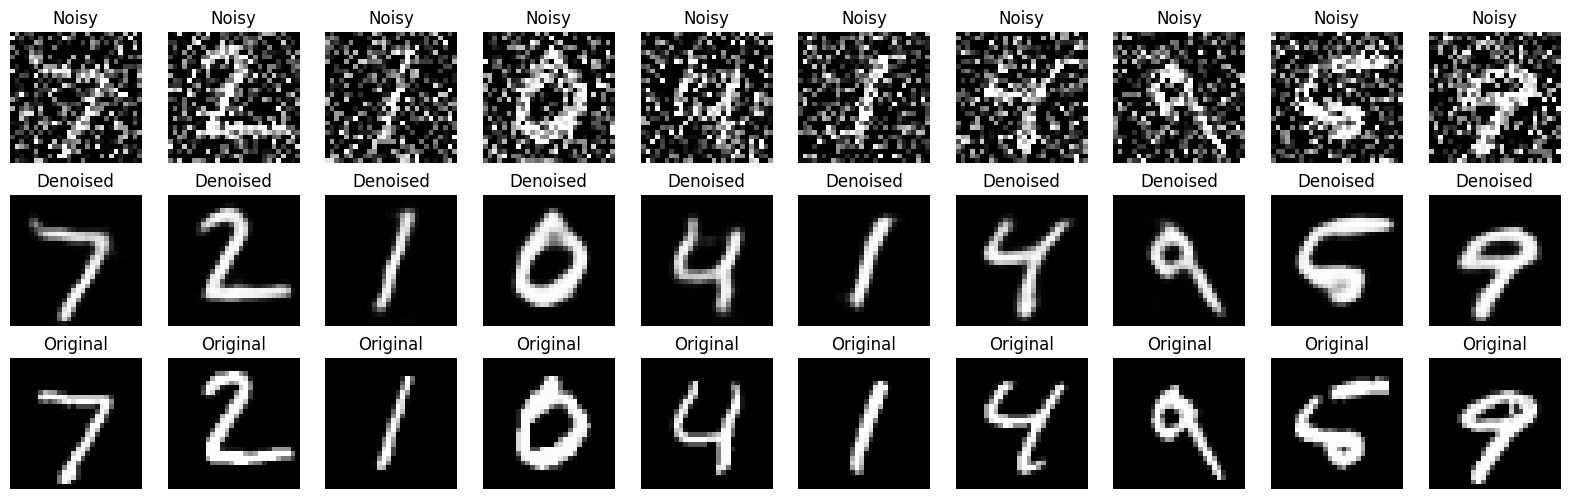

In [6]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")

    # original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
plt.show()